In [11]:
import pandas as pd
import vectorbt as vbt
import numpy as np

In [12]:
BTC = '../btc_data/BTC.pck'

In [33]:
df = pd.DataFrame(vbt.YFData.download('BTC-USD').get('Close'))
df = df[df.index>'2020-01-01']

/Users/k/miniconda3/envs/RAJ/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [34]:
df

,Close
Date,
2020-01-02 00:00:00+00:00,6985.470215
2020-01-03 00:00:00+00:00,7344.884277
2020-01-04 00:00:00+00:00,7410.656738
2020-01-05 00:00:00+00:00,7411.317383
2020-01-06 00:00:00+00:00,7769.219238
...,...
2024-10-11 00:00:00+00:00,62445.089844
2024-10-12 00:00:00+00:00,63193.023438
2024-10-13 00:00:00+00:00,62851.375000


In [50]:
# Przykładowe dane: zamknięcie BTC (symulowane lub pobrane z pliku)
btc_close = df['Close'].to_numpy()  # Zastąp rzeczywistymi danymi
fee = 0.001  # Opłata transakcyjna (np. 0.1%)
sl_percentages = np.round(np.linspace(0.01, 0.3, num=20), 2).tolist()
# Funkcja do obliczania zysków i strat

In [56]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Zakładamy, że df jest już zdefiniowane i zawiera dane
# btc_close = df['Close'].to_numpy()  # Zmiana ta jest zakładana

# Opłata transakcyjna
fee = 0.001  # Opłata transakcyjna (np. 0.1%)
initial_sl_percentage = 0.02  # 2% stop loss
trailing_stop_percentage = 0.01  # 1% trailing stop
activation_level_percentage = 0.02  # 2% powyżej ceny wejścia

class BTCProfitStrategy:
    def __init__(self, btc_close, fee, initial_sl_percentage, trailing_stop_percentage, activation_level_percentage):
        self.btc_close = btc_close
        self.fee = fee
        self.initial_sl_percentage = initial_sl_percentage
        self.trailing_stop_percentage = trailing_stop_percentage
        self.activation_level_percentage = activation_level_percentage
        self.total_profit = 0
        self.total_trades = 0
        self.total_btc = 0  # Łączna ilość BTC posiadanych przez użytkownika
        self.data = []  # Lista do zbierania danych do wykresu

    def test_strategy(self):
        # Otwarcie transakcji każdego dnia
        for i in range(len(self.btc_close) - 1):  # -1, żeby nie wychodzić poza zakres
            # Zakup BTC za 10 USD
            btc_purchased = 10 / self.btc_close[i]  # Ułamkowe BTC kupione
            entry_price = self.btc_close[i]  # Cena zakupu
            sl_price = entry_price * (1 - self.initial_sl_percentage)  # Ustalanie poziomu SL
            trailing_stop_price = None  # Inicjalizacja TSL
            activation_level = entry_price * (1 + self.activation_level_percentage)  # Poziom aktywacji TSL
            
            self.total_btc += btc_purchased  # Zwiększamy łączną ilość BTC

            # Zbieranie danych do wykresu
            self.data.append({
                'day': i,
                'btc_close': self.btc_close[i],
                'total_btc': self.total_btc,
                'total_profit': self.total_profit,
                'total_trades': self.total_trades,
                'sl_price': sl_price,
                'trailing_stop_price': trailing_stop_price
            })

            # Sprawdzamy ceny w kolejnych dniach
            for j in range(i + 1, len(self.btc_close)):
                current_price = self.btc_close[j]

                # Sprawdzenie poziomu aktywacji
                if self.total_btc > 0 and current_price >= activation_level:
                    # Aktywacja trailing stop
                    trailing_stop_price = current_price * (1 - self.trailing_stop_percentage)

                # Sprawdzenie stop loss
                if current_price <= sl_price:
                    # Zamknięcie pozycji na poziomie SL
                    exit_price = current_price
                    self.total_profit += (exit_price * self.total_btc) - (entry_price * self.total_btc) - (entry_price * self.total_btc * self.fee) - (exit_price * self.total_btc * self.fee)
                    self.total_trades += 1
                    self.total_btc = 0  # Resetujemy ilość BTC po zamknięciu pozycji
                    break

                # Sprawdzenie trailing stop
                if trailing_stop_price is not None and current_price <= trailing_stop_price:
                    # Zamknięcie pozycji na poziomie trailing stop
                    exit_price = current_price
                    self.total_profit += (exit_price * self.total_btc) - (entry_price * self.total_btc) - (entry_price * self.total_btc * self.fee) - (exit_price * self.total_btc * self.fee)
                    self.total_trades += 1
                    self.total_btc = 0  # Resetujemy ilość BTC po zamknięciu pozycji
                    break

                # Aktualizacja SL i TSL
                if self.total_btc > 0:
                    sl_price = max(sl_price, current_price * (1 - self.initial_sl_percentage))
                    if trailing_stop_price is not None:
                        trailing_stop_price = max(trailing_stop_price, current_price * (1 - self.trailing_stop_percentage))

                # Zbieranie danych
                self.data[-1]['total_profit'] = self.total_profit
                self.data[-1]['total_trades'] = self.total_trades
                self.data[-1]['sl_price'] = sl_price
                self.data[-1]['trailing_stop_price'] = trailing_stop_price

    def get_results(self):
        return self.total_profit, self.total_trades, self.data

# class BTCProfitPlot:
#     def __init__(self, data, btc_close):
#         self.data = data
#         self.btc_close = btc_close

#     def plot(self):
#         # Przygotowanie danych do wykresu
#         days = [entry['day'] for entry in self.data]
#         profits = [entry['total_profit'] for entry in self.data]

#         # Wykres w Plotly
#         fig = go.Figure()

#         # Dodajemy ślad dla kursu BTC
#         fig.add_trace(go.Scatter(
#             x=days,
#             y=self.btc_close[:len(days)],  # Upewniamy się, że długości są zgodne
#             mode='lines+markers',
#             name='BTC Close Price',
#             line=dict(color='blue'),
#             marker=dict(size=2),
#             yaxis='y1'  # Użycie pierwszej osi Y
#         ))

#         # Dodajemy ślad dla total profit
#         fig.add_trace(go.Scatter(
#             x=days,
#             y=profits,
#             mode='lines+markers',
#             name='Total Profit',
#             line=dict(color='orange'),
#             marker=dict(size=2),
#             yaxis='y2'  # Użycie drugiej osi Y
#         ))

#         # Ustawienia wykresu
#         fig.update_layout(
#             title='BTC Close Price and Total Profit Over Time',
#             xaxis_title='Days',
#             yaxis_title='BTC Close Price',
#             yaxis=dict(
#                 title='BTC Close Price',
#                 titlefont=dict(color='blue'),
#                 tickfont=dict(color='blue'),
#                 side='left'
#             ),
#             yaxis2=dict(
#                 title='Total Profit',
#                 titlefont=dict(color='orange'),
#                 tickfont=dict(color='orange'),
#                 overlaying='y',
#                 side='right'
#             ),
#             legend_title='Legend',
#             template='plotly_white',
#             hovermode='x unified'
#         )

#         # Wyświetlenie wykresu
#         fig.show()




Total Profit | Total Trades
---------------------------------
152.21       | 1742


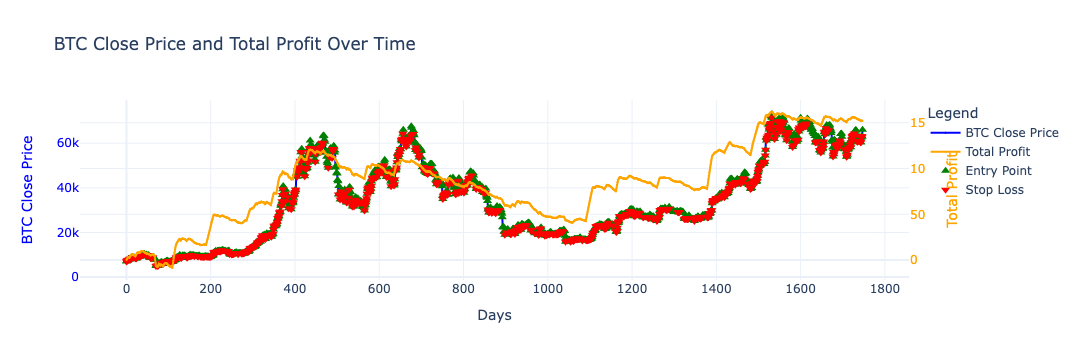

In [63]:
# Zakładamy, że btc_close jest już zdefiniowane
btc_close = df['Close'].to_numpy()

# Inicjalizacja i testowanie strategii
strategy = BTCProfitStrategy(btc_close, fee, initial_sl_percentage, trailing_stop_percentage, activation_level_percentage)
strategy.test_strategy()
total_profit, total_trades, data = strategy.get_results()

# Wyświetlenie wyników
print("Total Profit | Total Trades")
print("---------------------------------")
print(f"{total_profit:.2f}       | {total_trades}")

# Tworzenie i wyświetlanie wykresu
plotter = BTCProfitPlot(data, btc_close)
plotter.plot()

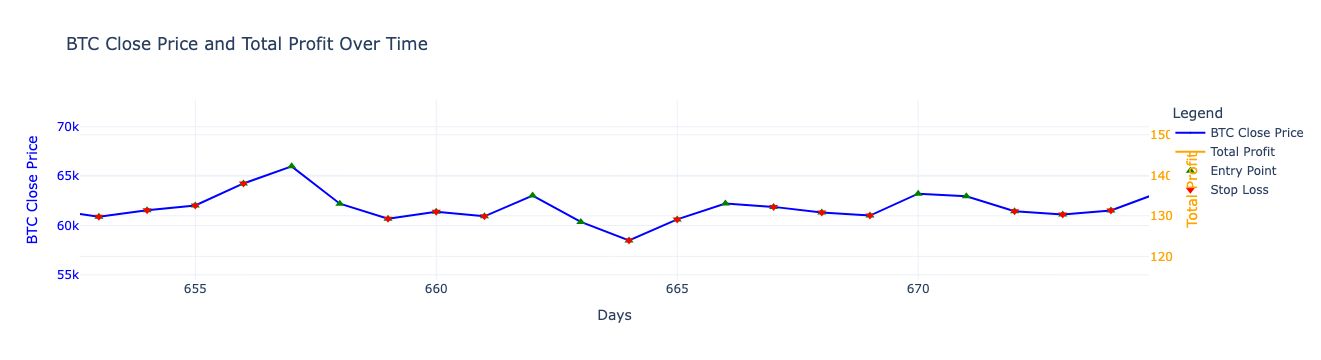

In [62]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

class BTCProfitPlot:
    def __init__(self, data, btc_close):
        self.data = data
        self.btc_close = btc_close

    def plot(self):
        # Przygotowanie danych do wykresu
        days = [entry['day'] for entry in self.data]
        profits = [entry['total_profit'] for entry in self.data]

        # Wykres w Plotly
        fig = go.Figure()

        # Dodajemy ślad dla kursu BTC
        fig.add_trace(go.Scatter(
            x=days,
            y=self.btc_close[:len(days)],  # Upewniamy się, że długości są zgodne
            mode='lines+markers',
            name='BTC Close Price',
            line=dict(color='blue'),
            marker=dict(size=2),
            yaxis='y1'  # Użycie pierwszej osi Y
        ))

        # Dodajemy ślad dla total profit
        fig.add_trace(go.Scatter(
            x=days,
            y=profits,
            mode='lines+markers',
            name='Total Profit',
            line=dict(color='orange'),
            marker=dict(size=2),
            yaxis='y2'  # Użycie drugiej osi Y
        ))

        # Dodawanie punktów oznaczających momenty wejścia i SL
        entry_days = [i for i, entry in enumerate(self.data) if entry['total_btc'] > 0]
        sl_days = [i for i, entry in enumerate(self.data) if entry['sl_price'] is not None and self.btc_close[i] <= entry['sl_price']]

        # Oznaczenie momentów wejścia (zielony trójkąt)
        fig.add_trace(go.Scatter(
            x=entry_days,
            y=[self.btc_close[day] for day in entry_days],
            mode='markers',
            name='Entry Point',
            marker=dict(color='green', symbol='triangle-up', size=8),
            yaxis='y1'
        ))

        # Oznaczenie momentów SL (czerwony okrąg)
        fig.add_trace(go.Scatter(
            x=sl_days,
            y=[self.btc_close[day] for day in sl_days],
            mode='markers',
            name='Stop Loss',
            marker=dict(color='red', symbol='triangle-down', size=8),
            yaxis='y1'
        ))

        # Ustawienia wykresu
        fig.update_layout(
            title='BTC Close Price and Total Profit Over Time',
            xaxis_title='Days',
            yaxis_title='BTC Close Price',
            yaxis=dict(
                title='BTC Close Price',
                titlefont=dict(color='blue'),
                tickfont=dict(color='blue'),
                side='left'
            ),
            yaxis2=dict(
                title='Total Profit',
                titlefont=dict(color='orange'),
                tickfont=dict(color='orange'),
                overlaying='y',
                side='right'
            ),
            legend_title='Legend',
            template='plotly_white',
            hovermode='x unified'
        )

        # Wyświetlenie wykresu
        fig.show()

# Zakładamy, że btc_close jest już zdefiniowane
btc_close = df['Close'].to_numpy()

# Inicjalizacja strategii i testowanie
strategy = BTCProfitStrategy(btc_close, fee, initial_sl_percentage, trailing_stop_percentage, activation_level_percentage)
strategy.test_strategy()
total_profit, total_trades, data = strategy.get_results()

# Tworzenie i wyświetlanie wykresu
plotter = BTCProfitPlot(data, btc_close)
plotter.plot()
